# Project 3
### Moiya Josephs

## Ask

Using any of the three classifiers described in chapter 6 of Natural Language Processing with Python, and any features you can think of, build the best name gender classifier you can. Begin by splitting the Names Corpus into three subsets: 500 words for the test set, 500 words for the dev-test set, and the remaining 6900 words for the training set. Then, starting with the example name gender classifier, make incremental improvements. Use the dev-test set to check your progress. Once you are satisfied with your classifier, check its final performance on the test set. How does the performance on the test set compare to the performance on the dev-test set? Is this what you'd expect?


## The Data Set

The names corpus is a collection of female and male names. As explained in the Chapter 6 of Natural Language Processing with Python textbook, female names often end in a, e or i and male names often end in k, o, r, s and t. Classifier models can be used to predict what bucket a name can fall in.

In [3]:
from nltk.corpus import names
import random

In [58]:
import nltk
import pandas as pd

In [5]:
nltk.download('names')

[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Unzipping corpora/names.zip.


True

### Combine the Male and Female Names

Combining both names from the datasets and labeling them to be either male or female.

In [7]:
labeled_names = ([(name, 'male') for name in names.words('male.txt')] +
                 [(name, 'female') for name in names.words('female.txt')])
random.shuffle(labeled_names)


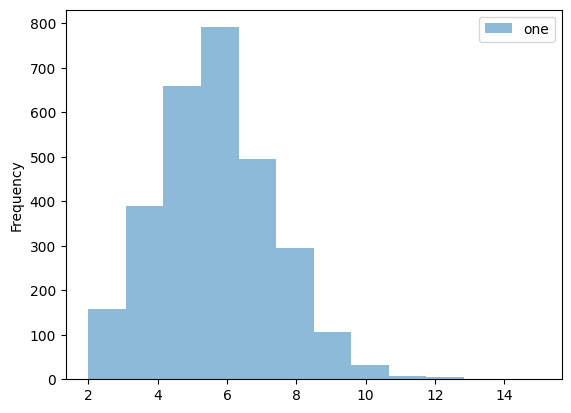

In [60]:
male_len = []
for name in names.words('male.txt'):
  male_len.append(len(name))

df = pd.DataFrame(male_len, columns=['one'])
ax = df.plot.hist(bins=12, alpha=0.5)


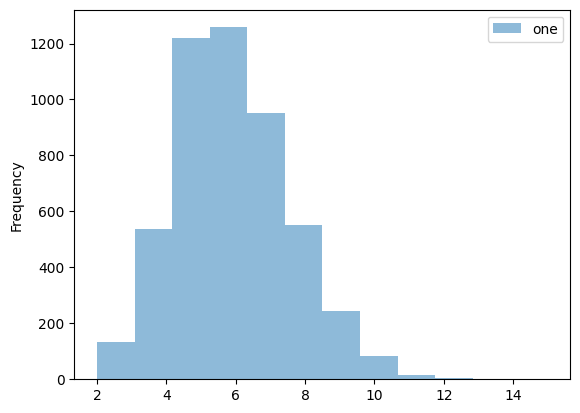

In [62]:
female_len = []
for name in names.words('female.txt'):
  female_len.append(len(name))

df = pd.DataFrame(female_len, columns=['one'])
ax = df.plot.hist(bins=12, alpha=0.5)

The distribution of the names lengths are similar but there are more names with 4 letters in the female text than the male.

According to the textbook, most male words end in "k", "o", "r", "s" and "t". According to the distirbution of the names text, this is shown to be not true at least for the given dataset. Even though this is opposite to the text, the opposite seems to be true so there is some correlation in the suffix.

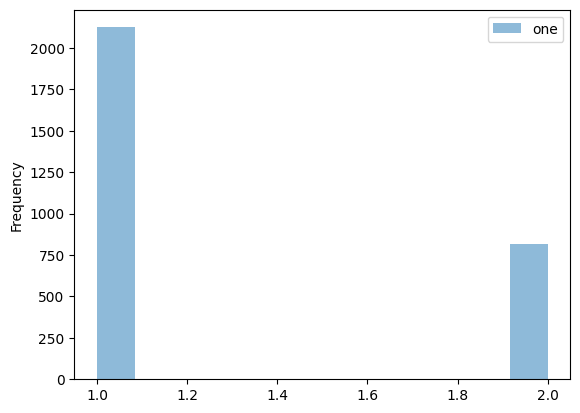

In [67]:
male_len = []
for name in names.words('male.txt'):
  if name[-1] in ("k", "o", "r", "s" , "t"):
    male_len.append(2)
  else:
    male_len.append(1)

df = pd.DataFrame(male_len, columns=['one'])
ax = df.plot.hist(bins=12, alpha=0.5)

According to the textbook, the female names end in "a", "e" and "i". In this dataset, this shows to be true.

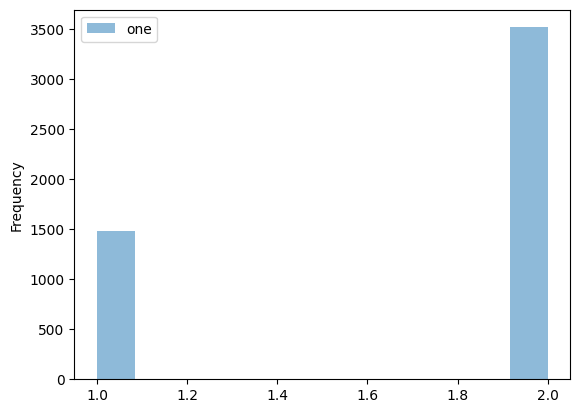

In [69]:
female_len = []
for name in names.words('female.txt'):
  if name[-1] in ("a", "e", "i"):
    female_len.append(2)
  else:
    female_len.append(1)

df = pd.DataFrame(female_len, columns=['one'])
ax = df.plot.hist(bins=12, alpha=0.5)

Splitting the labeled names by the training, devtest and test set. The training set is used to train the model and devtest is used to check against errors. At first I will train the dataset based on the last letter of the word.

In [61]:
def gender_features(word):
  return {'suffix1': word[-1:], 'suffix2': word[-2:]}

In [46]:
train_names = labeled_names[1500:]
devtest_names = labeled_names[500:1500]
test_names = labeled_names[:500]

In [47]:
train_set = [(gender_features(n), gender) for (n, gender) in train_names]
devtest_set = [(gender_features(n), gender) for (n, gender) in devtest_names]
test_set = [(gender_features(n), gender) for (n, gender) in test_names]

## Naives Classifier

In [48]:
classifier = nltk.NaiveBayesClassifier.train(train_set)
print(nltk.classify.accuracy(classifier, devtest_set))

0.761


Using just the last letter and the Naive Bayes Classifier, I can see the accuracy is 76%. To check the errors, we can use the dev-test set, and generate a list of the errors that the classifier makes when predicting name genders to see what was missed.



In [45]:
errors = []
for (name, tag) in devtest_names:
  guess = classifier.classify(gender_features_last(name))
  if guess != tag:
    errors.append( (tag, guess, name) )
for (tag, guess, name) in sorted(errors)[:10]:
  print('correct={:<8} guess={:<8s} name={:<30}'.format(tag, guess, name))

correct=female   guess=male     name=Abagael                       
correct=female   guess=male     name=Abigail                       
correct=female   guess=male     name=Anais                         
correct=female   guess=male     name=Anett                         
correct=female   guess=male     name=Annabel                       
correct=female   guess=male     name=Ardis                         
correct=female   guess=male     name=Ashlen                        
correct=female   guess=male     name=Audrey                        
correct=female   guess=male     name=Avrit                         
correct=female   guess=male     name=Bellamy                       


Errors in from the data set occur when the last two letters end n. The names appear to be more female when there is a vowel followed by the letter n or o. For presentation sake, I subset the error to show the first 10 errors.

I will create a genders features function to include the last letter and the last two letters of the words.


In [49]:
def gender_features(word):
  return {'suffix1': word[-1:], 'suffix2': word[-2:]}

In [50]:
train_set = [(gender_features(n), gender) for (n, gender) in train_names]
devtest_set = [(gender_features(n), gender) for (n, gender) in devtest_names]
test_set = [(gender_features(n), gender) for (n, gender) in test_names]

In [51]:
classifier = nltk.NaiveBayesClassifier.train(train_set)
print(nltk.classify.accuracy(classifier, devtest_set))

0.785


By including the last two letters the accuracy has increased to 78.5%. This is an improvement but I can increase the accuracy by also taking into account the first letter of the names.

In [29]:
def gender_features1(word):
  return {'first_letter': word[0], 'suffix1': word[-1:], 'suffix2': word[-2:]}

train_set = [(gender_features1(n), gender) for (n, gender) in train_names]
devtest_set = [(gender_features1(n), gender) for (n, gender) in devtest_names]
test_set = [(gender_features1(n), gender) for (n, gender) in test_names]

classifier = nltk.NaiveBayesClassifier.train(train_set)
print(nltk.classify.accuracy(classifier, devtest_set))

0.792


When including the first letter, the accuracy has now increased to 79.2%. Next, I will include the length of the names, working under the assumption that there is a correlation and difference between the length of female names compared to the length of male names.

In [35]:
def gender_features1(word):
  return {'first_letter': word[0].lower(), 'suffix1': word[-1:], 'suffix2': word[-2:], 'length': len(word)}

train_set = [(gender_features1(n), gender) for (n, gender) in train_names]
devtest_set = [(gender_features1(n), gender) for (n, gender) in devtest_names]
test_set = [(gender_features1(n), gender) for (n, gender) in test_names]

classifier = nltk.NaiveBayesClassifier.train(train_set)
print(nltk.classify.accuracy(classifier, devtest_set))

0.797


In [44]:
errors = []
for (name, tag) in devtest_names:
  guess = classifier.classify(gender_features1(name))
  if guess != tag:
    errors.append( (tag, guess, name) )

for (tag, guess, name) in sorted(errors)[:10]:
  print('correct={:<8} guess={:<8s} name={:<30}'.format(tag, guess, name))

correct=female   guess=male     name=Abagael                       
correct=female   guess=male     name=Abigail                       
correct=female   guess=male     name=Anais                         
correct=female   guess=male     name=Anett                         
correct=female   guess=male     name=Annabel                       
correct=female   guess=male     name=Ardis                         
correct=female   guess=male     name=Ashlen                        
correct=female   guess=male     name=Audrey                        
correct=female   guess=male     name=Avrit                         
correct=female   guess=male     name=Bellamy                       


Considering the length of the name along with the other criterias increases the accuracy to 79.9%.

In [36]:
def gender_features1(word):
  return {'first_letter': word[:2].lower(), 'suffix1': word[-1:], 'suffix2': word[-2:], 'length': len(word)}

train_set = [(gender_features1(n), gender) for (n, gender) in train_names]
devtest_set = [(gender_features1(n), gender) for (n, gender) in devtest_names]
test_set = [(gender_features1(n), gender) for (n, gender) in test_names]

classifier = nltk.NaiveBayesClassifier.train(train_set)
print(nltk.classify.accuracy(classifier, devtest_set))

0.799


The most informative features show that the suffix is the most informatice. In this example, the suffix 'na' shows to be 87.5 times more often in female names than in male. Also names ending in "rd" happen 29 times more often than in females.

In [37]:
classifier.show_most_informative_features(10)


Most Informative Features
                 suffix2 = 'na'           female : male   =     87.5 : 1.0
                 suffix2 = 'la'           female : male   =     63.7 : 1.0
                 suffix2 = 'ra'           female : male   =     55.0 : 1.0
                 suffix1 = 'k'              male : female =     40.1 : 1.0
                 suffix1 = 'a'            female : male   =     35.9 : 1.0
                 suffix2 = 'us'             male : female =     35.3 : 1.0
                 suffix2 = 'ia'           female : male   =     34.3 : 1.0
                 suffix2 = 'sa'           female : male   =     32.0 : 1.0
                 suffix2 = 'rd'             male : female =     29.0 : 1.0
                 suffix2 = 'ch'             male : female =     23.0 : 1.0


In [99]:
def gender_features1(word):
  features = {}
  features["first_letter"] = word[:2].lower()
  features["suffix1"] = word[-1:].lower()
  features["suffix2"] = word[-2:].lower()
  features["length"] = len(word)
  for letter in 'aeiou':
    features["count({})".format(letter)] = word.lower().count(letter)
  for letter in 'bcdfghjklmnpqrstvwxyz':
    features["count({})".format(letter)] = word.lower().count(letter)

  return features

In [100]:
train_set = [(gender_features1(n), gender) for (n, gender) in train_names]
devtest_set = [(gender_features1(n), gender) for (n, gender) in devtest_names]
test_set = [(gender_features1(n), gender) for (n, gender) in test_names]

classifier = nltk.NaiveBayesClassifier.train(train_set)
print(nltk.classify.accuracy(classifier, devtest_set))

0.805


In [101]:
classifier.show_most_informative_features(10)


Most Informative Features
                 suffix2 = 'na'           female : male   =     87.4 : 1.0
                 suffix2 = 'la'           female : male   =     64.0 : 1.0
                 suffix2 = 'ra'           female : male   =     54.9 : 1.0
                 suffix1 = 'k'              male : female =     40.1 : 1.0
                 suffix1 = 'a'            female : male   =     35.9 : 1.0
                 suffix2 = 'us'             male : female =     35.3 : 1.0
                 suffix2 = 'ia'           female : male   =     34.2 : 1.0
                 suffix2 = 'sa'           female : male   =     31.9 : 1.0
                 suffix2 = 'rd'             male : female =     29.1 : 1.0
                 suffix2 = 'ch'             male : female =     23.0 : 1.0


This method does not show any new imporatant information. The suffix continue to be the most informative features to be used to identify the male and female names. The best accuracy I achieved was 80.5%.

### Maxent Classifier

Maxent is memory hungry, slower, and it requires numpy. The Max Entropy classifier is a probabilistic classifier which belongs to the class of exponential models. It does not assume that the features are conditionally independent of each other.

In [102]:
from nltk import MaxentClassifier

classifier = MaxentClassifier.train(train_set, max_iter=25)

  ==> Training (25 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.368
             2          -0.58046        0.632
             3          -0.54560        0.640
             4          -0.51553        0.704
             5          -0.48972        0.755
             6          -0.46758        0.782
             7          -0.44854        0.797
             8          -0.43211        0.805
             9          -0.41785        0.811
            10          -0.40541        0.813
            11          -0.39448        0.817
            12          -0.38484        0.821
            13          -0.37628        0.824
            14          -0.36864        0.826
            15          -0.36178        0.826
            16          -0.35560        0.828
            17          -0.35001        0.828
            18          -0.34492        0.828
            19          -0.34028        0.829
  

In [103]:
classifier.show_most_informative_features(10)

  -2.787 suffix2=='na' and label is 'male'
  -2.710 suffix2=='la' and label is 'male'
  -2.702 suffix2=='ra' and label is 'male'
  -2.347 suffix1=='k' and label is 'female'
  -2.145 suffix2=='sa' and label is 'male'
  -2.122 suffix1=='a' and label is 'male'
  -2.094 suffix2=='us' and label is 'female'
  -2.036 suffix2=='ch' and label is 'female'
  -1.963 suffix2=='ia' and label is 'male'
  -1.962 suffix2=='sy' and label is 'male'


Using the Maxent Classifier method, it shows a more informative outputs. The accuracy is also achieves a 83.3

## Conclusion



By using the Maxent Classifier and the optimal gender features I am able to achieve 83.9% accuracy. With NaiveClassifier, I was able to achiece 80.5% accuracy. The most important features are the suffix when considering the last two letters. Features like the frequency of vowels